#### Build a image x label adjacency matrix (oh i miss babai)

In [2]:
import os
import numpy as np
import re
import csv
import glob
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
DATA_DIRECTORY = "../../../project/rcc/deep_learning_hack/netdissect/broden1_224/"
OUTPUT_FOLDER = "../../../project2/bermanm/netdissect/"

categories_pixels = ['color', 'object', 'part', 'material']
categories_scalars = ['scene', 'texture']

In [4]:
def decode_index_dict(row):
    result = {}
    for key, val in row.items():
        if key in ['image', 'split']:
            result[key] = val
        elif key in ['sw', 'sh', 'iw', 'ih']:
            result[key] = int(val)
        else:
            item = [s for s in val.split(';') if s]
            for i, v in enumerate(item):
                if re.match('^\d+$', v):
                    item[i] = int(v)
            result[key] = item
    return result

In [5]:
def decode_label_dict(row):
    result = {}
    for key, val in row.items():
        if key == 'category':
            result[key] = dict((c, int(n))
                for c, n in [re.match('^([^(]*)\(([^)]*)\)$', f).groups()
                    for f in val.split(';')])
        elif key == 'name':
            result[key] = val
        elif key == 'syns':
            result[key] = val.split(';')
        elif re.match('^\d+$', val):
            result[key] = int(val)
        elif re.match('^\d+\.\d*$', val):
            result[key] = float(val)
        else:
            result[key] = val
    return result

In [6]:
with open(os.path.join(DATA_DIRECTORY, "index.csv")) as f:
    images = [decode_index_dict(r) for r in csv.DictReader(f)]

In [7]:
with open(os.path.join(DATA_DIRECTORY, "label.csv")) as f:
    labels = [decode_label_dict(r) for r in csv.DictReader(f)]

In [10]:
def build_image_vs_label(images, labels, save_path="matrix.npy"):
    if not os.path.exists(os.path.join(OUTPUT_FOLDER, "visualization")):
        os.makedirs(os.path.join(OUTPUT_FOLDER, 'visualization'))
    save_path = os.path.join(OUTPUT_FOLDER, "visualization", save_path)
    if os.path.exists(save_path):
        print("loading")
        return np.load(save_path)
    
    image_vs_label = np.zeros((len(images), len(labels)+1))
    for i, image in enumerate(images):
        if (i % 100 == 0):
            print(i)
        lbs = np.array([])
        for cat in categories_pixels:
            for lb_img in image[cat]:
                lb_img = Image.open(os.path.join(DATA_DIRECTORY, "images", lb_img))
                cat_lbs = np.unique(np.array(list(lb_img.getdata())))[1:]
                lbs = np.concatenate((lbs, cat_lbs))
        for cat in categories_scalars:
            lbs = np.concatenate((lbs, np.array(image[cat])))
        lbs = np.unique(lbs.astype(int))
        image_vs_label[i].put(lbs, [1])
    np.save(save_path, image_vs_label)
    return image_vs_label

In [19]:
ivl = build_image_vs_label(images, labels)

loading


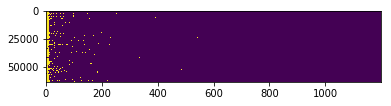

In [22]:
plt.imshow(ivl, aspect=0.004)

In [21]:
sums = np.array([sum(ivl[i]) for i in range(ivl.shape[0])])

In [20]:
np.argmax(sums)

60496

In [23]:
images[60496]

{'image': 'ade20k/ADE_train_00010274.jpg',
 'split': 'val',
 'ih': 224,
 'iw': 224,
 'sh': 112,
 'sw': 112,
 'color': ['ade20k/ADE_train_00010274_color.png'],
 'object': ['ade20k/ADE_train_00010274_object.png'],
 'part': ['ade20k/ADE_train_00010274_part_1.png',
  'ade20k/ADE_train_00010274_part_2.png',
  'ade20k/ADE_train_00010274_part_3.png'],
 'material': [],
 'scene': [134],
 'texture': []}

In [24]:
ivl[60496].nonzero()

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,
         15,  22,  23,  25,  27,  31,  35,  36,  37,  40,  41,  44,  45,
         50,  54,  57,  64,  70,  72,  74,  76,  78,  79,  81,  88,  90,
         91,  96,  97, 102, 107, 108, 116, 124, 125, 133, 134, 144, 161,
        170, 174, 179, 190, 194, 205, 207, 219, 220, 229, 235, 252, 254]),)

In [25]:
cp = {0: (230, 255, 255),
        1: (0, 0, 0),
          2: (128, 128, 128),
          3: (255, 255, 255),
          4: (153, 102, 51),
          5: (0, 153, 51),
          6: (255, 153, 204),
          7: (153, 0, 255),
          8: (0, 0, 204),
          9: (255, 204, 0),
          10: (204, 0, 0),
          11: (255, 153, 0)}

In [26]:
size = 112
gap = 3
img_row = 432
img_col = 288

In [35]:
def pixel_concepts(image_id, img, concept, palette, labels=labels):
    concept_labels = img[concept]
    for lbi, lb in enumerate(concept_labels):
        c_img = Image.open(os.path.join(DATA_DIRECTORY, "images", lb))
        unique_label = list(c_img.getdata())
        unique_label = np.unique(np.array([c[0] for c in unique_label]))
        unique_label = np.array([c for c in unique_label if c != 0])
        if list(unique_label) != []:
            label_map = {}
            label_map[0] = 0
            for i, label in enumerate(unique_label):
                label_map[label] = i+1

            c_pixel = c_img.load()
            gdheight = 1
            gdwidth = len(unique_label) + 1
            if concept == 'color':
                tiled = np.full(((size + gap) * gdheight - gap, (size + gap) * gdwidth - gap, 3), 255, dtype='uint8')
            else:
                tiled = np.full(((size + gap) * gdheight - gap, (size + gap) * gdwidth - gap, 4), 0, dtype='float')

            row = 0
            for col in range(len(unique_label) + 1):
                if col == len(unique_label):
                     c_img = np.array([[palette[label_map[c_pixel[i, j][0]]] for i in range(size)]
                         for j in range(size)])
                else:
                    c = unique_label[col]
                    c_img = np.array([[palette[label_map[c]] if c_pixel[i, j][0] == c else palette[0]
                               for i in range(size)] for j in range(size)])
                tiled[row * (size + gap) : row * (size + gap) + size, 
                        col * (size + gap) : col * (size + gap) + size,:] = c_img

            locs = np.arange(size // 2, gdwidth * size, size + gap)
            curr_labels = [labels[c-1]['name'] for c in unique_label] + ['combined']
            filename = str(image_id) + "_" + concept + "_" + str(lbi + 1) + ".png"
            plt.xticks(locs, curr_labels, rotation=90)
            plt.title(concept + " " + str(lbi + 1))
            plt.imshow(tiled)
            plt.savefig(os.path.join(OUTPUT_FOLDER, "visualization", filename), dpi=1000)
            plt.close()

In [28]:
def scalar_concepts(img, concept, labels=labels):
    res = ""
    if img[concept] != []:
        res = concept + ": "
        lbs = [labels[c-1]["name"] for c in img[concept]]
        res += ";".join(lbs)
    return res

In [29]:
def build_image(image_id, image_name, title):
    image = Image.open(os.path.join(DATA_DIRECTORY, "images", image_name))
    plt.imshow(image)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(OUTPUT_FOLDER, "visualization", str(image_id) + ".png"), dpi=1000)

In [60]:
def probe(image_id, mode=None, images=images, labels=labels, color_palette=cp, max_labels=60):
    hsv = plt.get_cmap('hsv')
    dp = hsv(np.linspace(0, 1.0, 60))
    dp = np.random.permutation(dp)
    dp_map = {}
    for i in range(max_labels):
        if i == 0:
            dp_map[i] = [0., 0.8, 1., 0.05]
        else:
            dp_map[i] = dp[i]

    img = images[image_id]
    img_name = img['image']
    dataset = img_name.split("/")[0]
    filename = img_name.split("/")[1]
    
    title = dataset + "_" + filename
    build_image(image_id, img_name, title)
    print("Dataset: {}".format(dataset))
    print("Image Name: {}".format(filename))

    pixel_concepts(image_id, img, "color", color_palette)
    pixel_concepts(image_id, img, "object", dp_map)
    pixel_concepts(image_id, img, "part", dp_map)
    pixel_concepts(image_id, img, "material", dp_map)
    
    if mode != None:
        file = os.path.join(OUTPUT_FOLDER, "visualization", str(image_id) + "_" + mode[:-1] + "_" + mode[-1] + ".png")
        f_img = Image.open(file)
        plt.imshow(f_img)
        plt.xticks([])
        plt.yticks([])
    else:
        files = sorted(glob.glob(os.path.join(OUTPUT_FOLDER, "visualization", str(image_id) + "*.png")))
        length = len(files)

        result = Image.new("RGB", (img_row, img_col * (length)))
        for i, file in enumerate(files):
            r_img = Image.open(file)
            r_img.thumbnail((img_row, img_col), Image.ANTIALIAS)
            x = i // (length) * img_row
            y = i % (length) * img_col
            w, h = r_img.size
            result.paste(r_img, (x, y, x + w, y + h))

        plt.imshow(result)
        plt.xticks([])
        plt.yticks([])
        #plt.suptitle(title, size="large")
        scene = scalar_concepts(img, "scene")
        texture = scalar_concepts(img, "texture")
        subtitle = "[" + str(image_id) + "] " + scene + " " + texture
        plt.title(subtitle, size="large")
        filename = os.path.join(OUTPUT_FOLDER, "visualization", str(image_id) + "_combined.jpg")
        plt.savefig(filename, dpi=1000)

Dataset: ade20k
Image Name: ADE_train_00007855.jpg


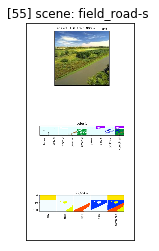

In [65]:
p = probe(55)

In [ ]:
filename = os.path.join(OUTPUT_FOLDER, "visualization", str(60496) + "_combined.jpg")
view = Image.open(filename)

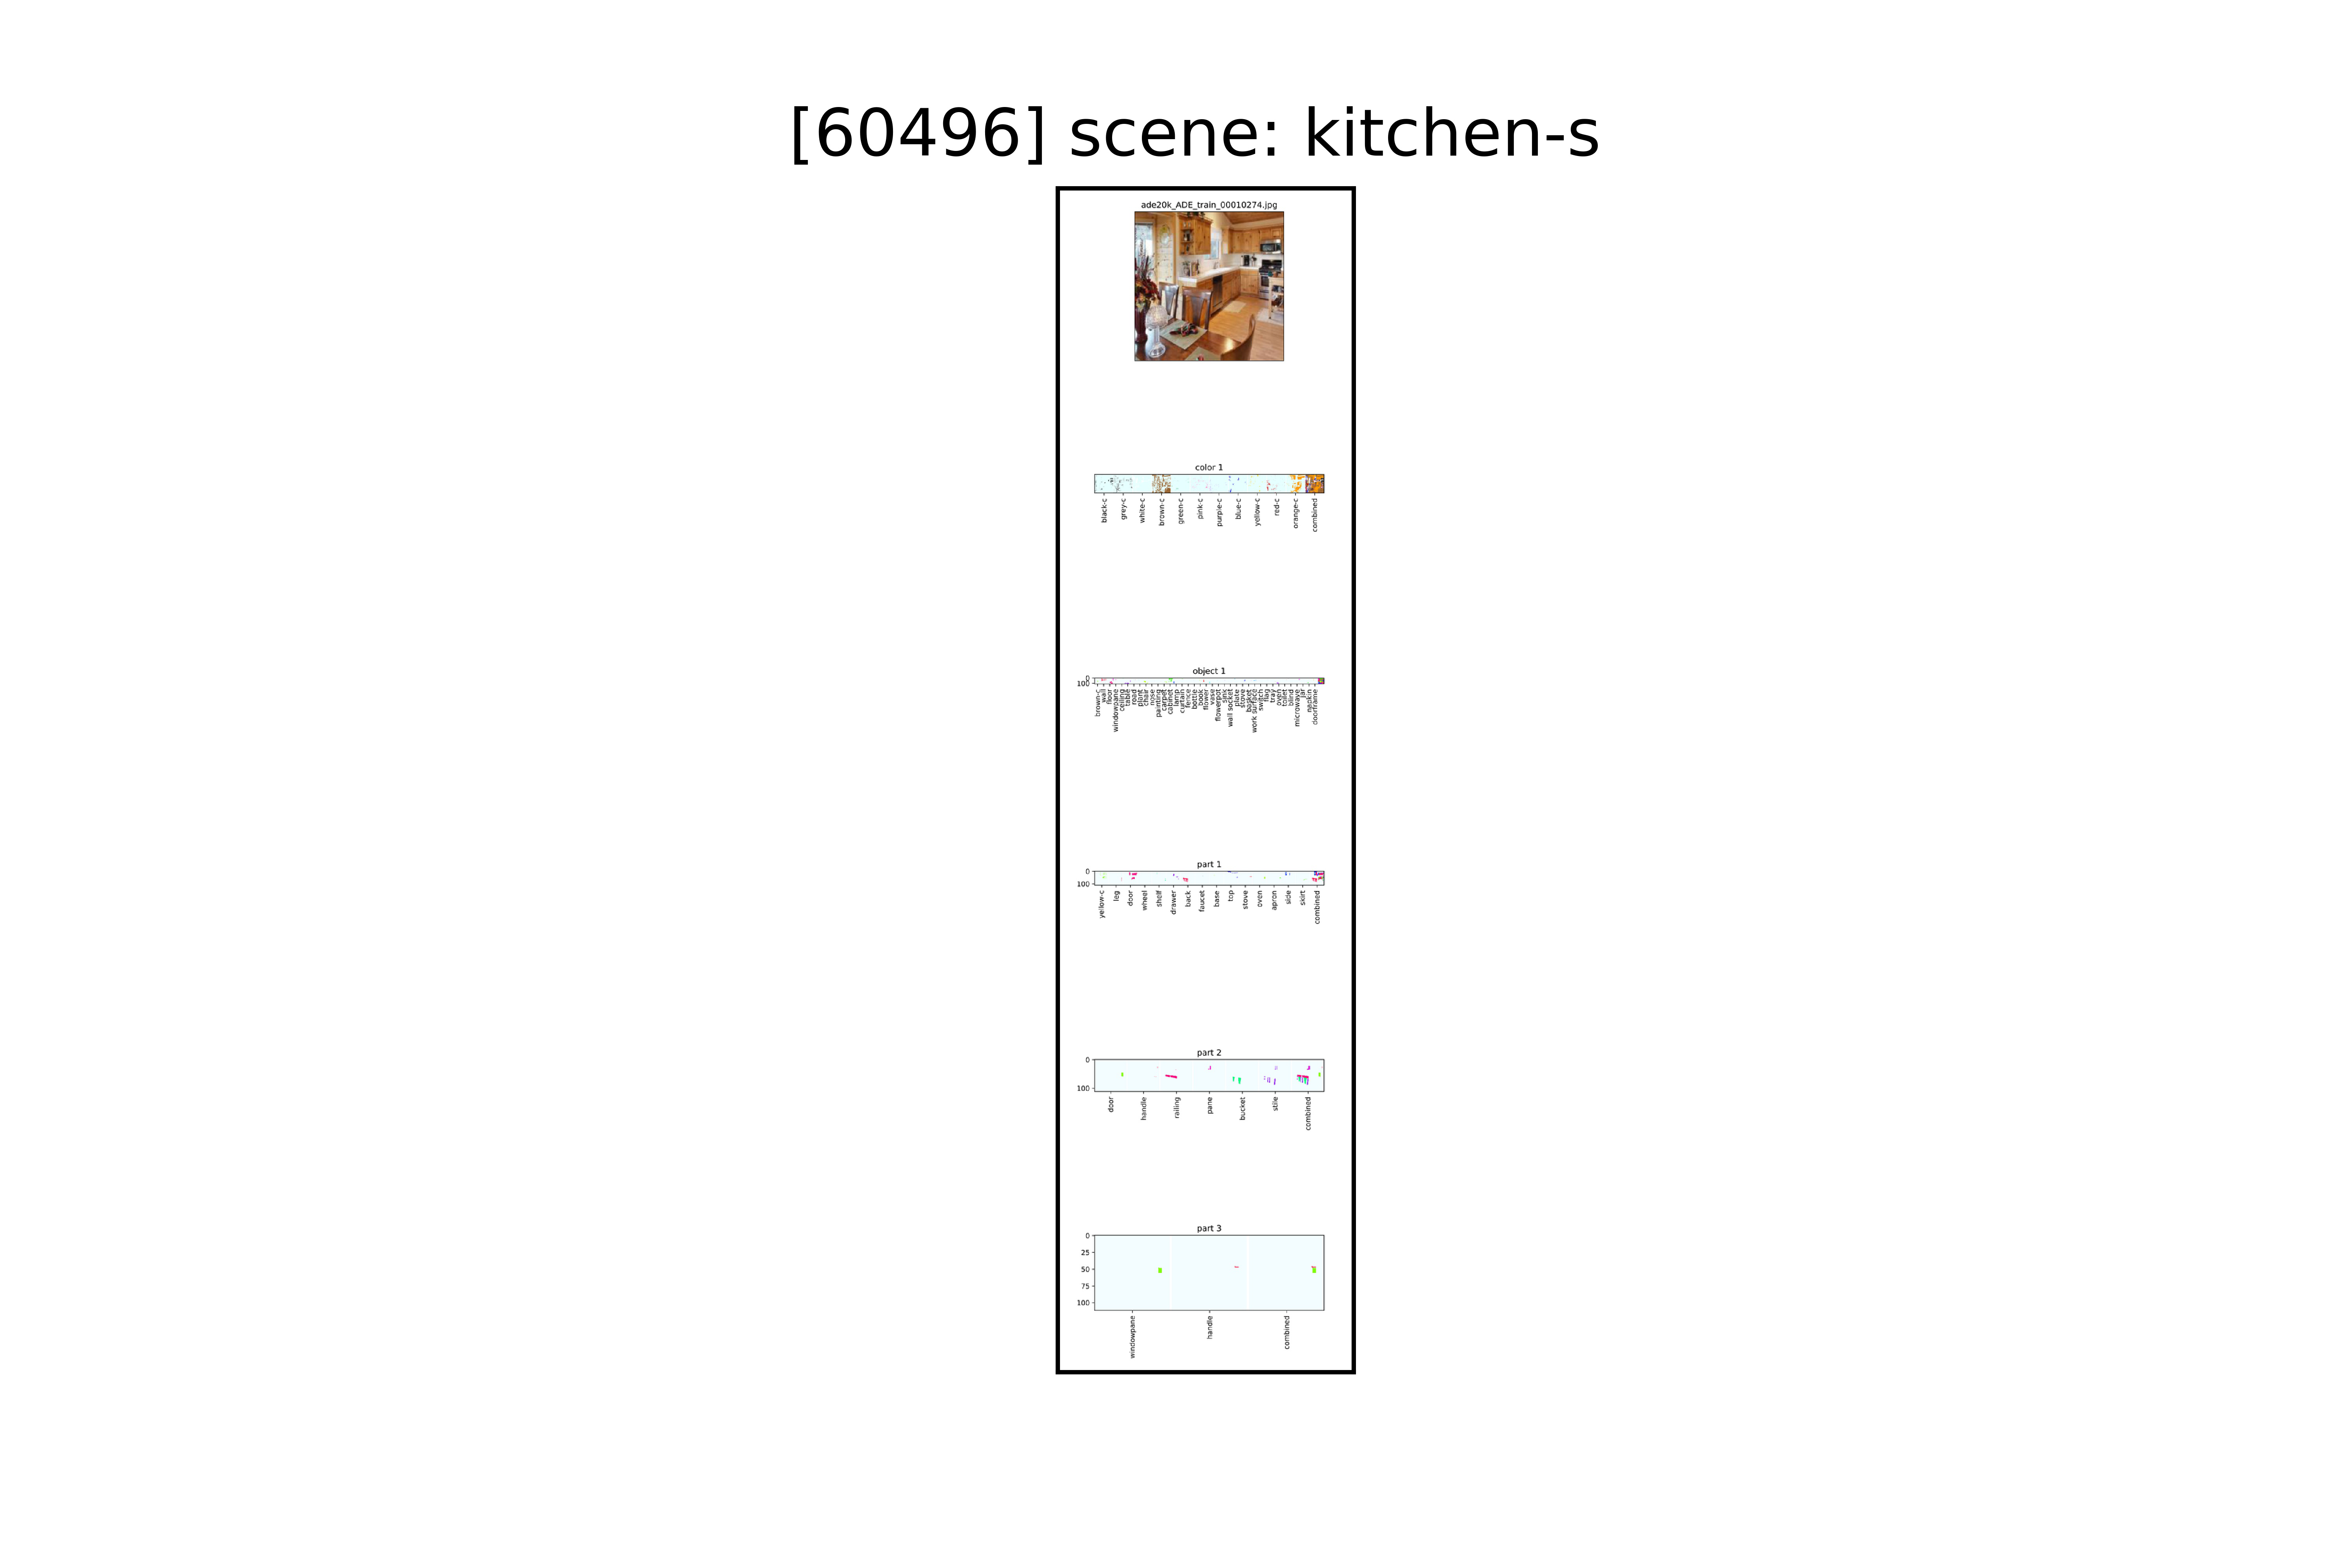

In [64]:
view